<a href="https://colab.research.google.com/github/Akompalwad/Sentimental-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.lib.io.tf_record import TFRecordWriter
from sklearn.model_selection import train_test_split
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [2]:
# this section is needed only if you get some error in nltk, it wouldnt hurt to
# to run it though
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('/content/drive/My Drive/datasets/train_twitter.csv',sep=",",header=0)

In [4]:
df = df[['label','tweet']]

In [5]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [6]:
#This tells us about the distribution of data
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

**It can be seen that the data is highly imbalanced and number of positive tweets
is too high than number of negative tweets
For a good deep learning model it is really helpful when both the tweets are balanced.
  It is highly important that the data is not skewed.**

In [7]:
df_positive = df[df['label']==0]
df_negative = df[df['label']==1]

In [126]:
df_train_positive = df_positive.sample(7000)
df_train_negative = df_negative
print("Train positive shape",df_train_positive.shape)
print("Train negative shape",df_train_negative.shape)

Train positive shape (7000, 2)
Train negative shape (2242, 2)


In [127]:
train_df = pd.concat([df_train_positive,df_train_negative])
print(train_df.shape)
print("\n")
train_df.head()

(9242, 2)




,label,tweet
4802,0,the sad moment when you walk into a bookstore ...
25165,0,@user aren't #boiledpeanuts green when @user c...
28995,0,best essential oils for #healing!! #altways...
13840,0,@user bihday haryana clpleader
4494,0,on the train to nyc!! then virginia! ð ð ...


In [128]:
train_df['tweet_n'] = train_df['tweet'].apply(lambda x:x.split())
train_df.head()

,label,tweet,tweet_n
4802,0,the sad moment when you walk into a bookstore ...,"[the, sad, moment, when, you, walk, into, a, b..."
25165,0,@user aren't #boiledpeanuts green when @user c...,"[@user, aren't, #boiledpeanuts, green, when, @..."
28995,0,best essential oils for #healing!! #altways...,"[best, essential, oils, for, #healing!!, #altw..."
13840,0,@user bihday haryana clpleader,"[@user, bihday, haryana, clpleader]"
4494,0,on the train to nyc!! then virginia! ð ð ...,"[on, the, train, to, nyc!!, then, virginia!, ð..."


In [129]:
stemmer = PorterStemmer()
train_df['tweet_n']= train_df['tweet_n'].apply(lambda x:[stemmer.stem(i) for i in x])
train_df.head()

,label,tweet,tweet_n
4802,0,the sad moment when you walk into a bookstore ...,"[the, sad, moment, when, you, walk, into, a, b..."
25165,0,@user aren't #boiledpeanuts green when @user c...,"[@user, aren't, #boiledpeanut, green, when, @u..."
28995,0,best essential oils for #healing!! #altways...,"[best, essenti, oil, for, #healing!!, #altways..."
13840,0,@user bihday haryana clpleader,"[@user, bihday, haryana, clpleader]"
4494,0,on the train to nyc!! then virginia! ð ð ...,"[on, the, train, to, nyc!!, then, virginia!, ð..."


In [130]:
train_df['tweet_n'] = train_df['tweet_n'].apply(lambda x:str(" ".join(i for i in x)))
train_df.head()

,label,tweet,tweet_n
4802,0,the sad moment when you walk into a bookstore ...,the sad moment when you walk into a bookstor a...
25165,0,@user aren't #boiledpeanuts green when @user c...,@user aren't #boiledpeanut green when @user co...
28995,0,best essential oils for #healing!! #altways...,best essenti oil for #healing!! #altwaystoh #h...
13840,0,@user bihday haryana clpleader,@user bihday haryana clpleader
4494,0,on the train to nyc!! then virginia! ð ð ...,on the train to nyc!! then virginia! ð ð #...


In [131]:
def text_processing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [132]:
x_train,x_test,y_train,y_test = train_test_split(train_df['tweet_n'],train_df['label'],test_size = 0.2,random_state = 14)

In [133]:
#Machine Learning Pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(solver='liblinear')),  # train on logistic regression model
])
pipeline.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_processing at 0x7f0868a056a8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                            

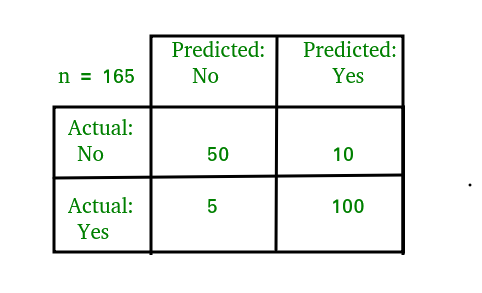

In [134]:
predictions = pipeline.predict(x_test)

print(classification_report(predictions,y_test))
print ('\n')
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1596
           1       0.54      0.92      0.68       253

    accuracy                           0.88      1849
   macro avg       0.76      0.90      0.81      1849
weighted avg       0.92      0.88      0.89      1849



[[1401  195]
 [  21  232]]
0.8831800973499189


In [135]:
test_data = pd.read_csv('/content/drive/My Drive/datasets/test_tweets.csv')
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [136]:
test_data['tweet'] = test_data['tweet'] .apply(lambda x:x.split())
test_data['tweet']= test_data['tweet'].apply(lambda x:[stemmer.stem(i) for i in x])
test_data['tweet'] = test_data['tweet'].apply(lambda x:str(" ".join(i for i in x)))

In [137]:
result = pipeline.predict(test_data['tweet'])
result_df = pd.DataFrame(result)

In [138]:
result_df.to_csv('result13.csv')

In [ ]:
# The above submission gives 0.62 F1 score on the test dataset of Analytics Vidhya